## EDA for the unemployment Rate in Kenya

In [1]:
import os
import re
import shutil
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
%matplotlib inline
import matplotlib.pyplot as plt
import dtale 
import dtale.app as dtale_app
dtale_app.USE_COLAB = True
import sweetviz as sv
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler


### Define functions for repeated tasks


In [2]:
# Function to extract headers from a given file
def extract_headers(file_path):
    try:
        # Read the first sheet of the Excel file
        df = pd.read_excel(file_path)
        
        # Get the column headers
        headers = df.columns.tolist()
        
        return headers
    except Exception as e:
        return []
##########################################


def replace_characters(dataframe):
    # Iterate through the columns and update their names
    for col in dataframe.columns:
        # replace spaces, whitespaces, parenthesis with underscore and remove commas and % signs
        new_col_name = re.sub(r'[\s(),]+', '_', col).strip('_')
        new_col_name = re.sub(r'%', 'Percent', new_col_name)
        
        # Update the column name in the DataFrame
        dataframe.rename(columns={col: new_col_name}, inplace=True)

    # Return a list of the modified column names
    return dataframe.columns

##########################################
# replace dataframe datatype to numeric if it is actually numeric
def convert_to_float_or_pass(input_string):
    try:
        result = float(input_string)
        return result
    except ValueError:
        pass

# create barplots for all columns
# Create separate subplots for each column
def barplots(df):
    nrows=int(len(df.columns)/2)
    fig, axes = plt.subplots(nrows=nrows,ncols=len(df.columns)-nrows, figsize=(15, 5))
    for i, col in enumerate(df.columns):
        sns.barplot(x=df.index, y=col, data=df, ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_xlabel('Year')
        axes[i].set_ylabel('Value')

        plt.tight_layout()
    return plt.show()

# compare columns
def lineplot(key,df):
    plt.figure(figsize=(14,8))
    filtered_cols=[col for col in df.columns  if str(key) in col.casefold()]
    for column in filtered_cols:
        plt.plot(df.index, df[column], marker='o', linestyle='-', label=column)
        
        plt.title('')
        plt.xlabel('Year')
        plt.ylabel('Scaled Value')
        #plt.legend()
        plt.grid(True)
    plt.plot(df.index,df['Unemployment_total_Percent_of_total_labor_force_modeled_ILO_estimate'],marker='x',linestyle='--',label='Total Unemployment Rate')    
    plt.legend()
    return plt.show()    



            

## Read the data into dataframe(s) and rename the column names for easy readibility

In [58]:
population_projected=pd.read_excel("preprocessing_dataset.xlsx",skiprows=1,sheet_name=1)
unemployment_historical=pd.read_excel("Final_preprocessing_dataset.xlsx",skiprows=1)
unemployment_historical.columns=replace_characters(unemployment_historical)
unemployment_historical.shape
unemployment_historical.head()


,Year,Unemployment_Rate_Percent,Inflation_Rate,Labour_Force,Nominal_GDP_prices_Ksh_Million,Annual_GDP_growth_Percent,Real_GDP_prices_Ksh_Million,population_growth,Population_total,Urban_population_growth_annual_Percent,Adjusted_net_national_income_per_capita_annual_Percent_growth,Adjusted_savings:_education_expenditure_current_US$,Labor_force_participation_rate_for_ages_15-24_female_Percent_modeled_ILO_estimate,Labor_force_participation_rate_for_ages_15-24_male_Percent_modeled_ILO_estimate,Unemployment_female_Percent_of_female_labor_force_modeled_ILO_estimate,Unemployment_male_Percent_of_male_labor_force_modeled_ILO_estimate,Unemployment_total_Percent_of_total_labor_force_modeled_ILO_estimate
0,2000,0.0313,9.98,12114213,967838,0.0,982855,2.92,30851606,0.07,-2.81,645127096.87,50.46,46.89,3.37,2.89,3.13
1,2001,0.0307,5.73,12601491,1020022,3.8,1020111,3.03,31800343,1.95,-1.09,656047739.08,50.03,46.87,3.31,2.84,3.07
2,2002,0.0309,1.97,13103364,1035374,0.5,1025583,3.03,32779823,0.67,-2.34,755517161.8,49.61,46.84,3.33,2.86,3.09
3,2003,0.0304,9.81,13606235,1131783,2.9,1055658,2.97,33767122,0.49,-2.44,897571127.36,49.18,46.82,3.28,2.82,3.04
4,2004,0.0300,11.80,14125163,1274328,5.1,1109338,2.99,34791836,5.82,2.7,1011467728.44,48.76,46.79,3.23,2.77,3.00


In [56]:
population_projected

,County,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
0,Kenya*.,28757,29551,30346,31140,31935,32729,33514,34298,35083,35867,36651
1,Mombasa*.,779,801,824,846,869,891,913,936,958,980,1003
2,Kwale*.,456,475,494,512,531,549,568,588,607,626,645
3,Kilifi*.,876,897,919,940,962,983,1004,1025,1046,1067,1087
4,Tana River*.,160,167,173,180,186,193,200,208,215,223,231
5,Lamu*.,85,88,92,95,99,102,106,110,113,117,121
6,Taita Taveta*.,213,216,220,223,227,231,234,238,241,245,248
7,Garissa*.,477,494,510,527,543,559,576,593,610,626,643
8,Wajir*.,413,433,453,473,492,512,532,553,573,593,614
9,Mandera*.,452,473,494,516,537,559,580,602,623,645,666


## Check the data types


In [4]:
unemployment_historical['Year']=pd.to_datetime(unemployment_historical['Year'],format='%Y').dt.year
unemployment_historical.dtypes
unemployment_historical

,Year,Unemployment_Rate_Percent,Inflation_Rate,Labour_Force,Nominal_GDP_prices_Ksh_Million,Annual_GDP_growth_Percent,Real_GDP_prices_Ksh_Million,population_growth,Population_total,Urban_population_growth_annual_Percent,Adjusted_net_national_income_per_capita_annual_Percent_growth,Adjusted_savings:_education_expenditure_current_US$,Labor_force_participation_rate_for_ages_15-24_female_Percent_modeled_ILO_estimate,Labor_force_participation_rate_for_ages_15-24_male_Percent_modeled_ILO_estimate,Unemployment_female_Percent_of_female_labor_force_modeled_ILO_estimate,Unemployment_male_Percent_of_male_labor_force_modeled_ILO_estimate,Unemployment_total_Percent_of_total_labor_force_modeled_ILO_estimate
0,2000,0.0313,9.98,12114213,967838,0.0,982855,2.92,30851606,0.07,-2.81,645127096.87,50.46,46.89,3.37,2.89,3.13
1,2001,0.0307,5.73,12601491,1020022,3.8,1020111,3.03,31800343,1.95,-1.09,656047739.08,50.03,46.87,3.31,2.84,3.07
2,2002,0.0309,1.97,13103364,1035374,0.5,1025583,3.03,32779823,0.67,-2.34,755517161.8,49.61,46.84,3.33,2.86,3.09
3,2003,0.0304,9.81,13606235,1131783,2.9,1055658,2.97,33767122,0.49,-2.44,897571127.36,49.18,46.82,3.28,2.82,3.04
4,2004,0.0300,11.80,14125163,1274328,5.1,1109338,2.99,34791836,5.82,2.7,1011467728.44,48.76,46.79,3.23,2.77,3.00
5,2005,0.0297,9.91,14646884,1415823,5.7,1172784,2.98,35843010,8.3,5.13,1215687557.67,48.34,46.77,3.20,2.75,2.97
6,2006,0.0294,6.03,15171370,1622565,6.5,1249470,2.97,36925253,14.29,10.94,1710161374.1,47.91,46.75,3.17,2.73,2.94
7,2007,0.0292,4.27,15697007,1833511,6.9,1336849,2.97,38036793,4.85,1.79,1972468804.57,47.48,46.72,3.14,2.71,2.92
8,2008,0.0298,15.11,16235546,2107589,1.5,1357262,2.98,39186895,2.18,-0.82,2065737290.63,47.05,46.71,3.19,2.77,2.98
9,2009,0.0292,10.54,16792371,3275642,2.7,5361462,2.96,40364444,-4.45,-7.24,1967168900.61,46.62,46.69,3.13,2.72,2.92


## Convert the Year column into index and convert the series into time series

In [5]:
unemployment_historical.index=pd.to_datetime(unemployment_historical['Year'],format='%Y').dt.year
unemployment_historical=unemployment_historical.drop(['Year','Unemployment_Rate_Percent'],axis=1)
unemployment_historical.head()


,Inflation_Rate,Labour_Force,Nominal_GDP_prices_Ksh_Million,Annual_GDP_growth_Percent,Real_GDP_prices_Ksh_Million,population_growth,Population_total,Urban_population_growth_annual_Percent,Adjusted_net_national_income_per_capita_annual_Percent_growth,Adjusted_savings:_education_expenditure_current_US$,Labor_force_participation_rate_for_ages_15-24_female_Percent_modeled_ILO_estimate,Labor_force_participation_rate_for_ages_15-24_male_Percent_modeled_ILO_estimate,Unemployment_female_Percent_of_female_labor_force_modeled_ILO_estimate,Unemployment_male_Percent_of_male_labor_force_modeled_ILO_estimate,Unemployment_total_Percent_of_total_labor_force_modeled_ILO_estimate
Year,,,,,,,,,,,,,,,
2000,9.98,12114213,967838,0.0,982855,2.92,30851606,0.07,-2.81,645127096.87,50.46,46.89,3.37,2.89,3.13
2001,5.73,12601491,1020022,3.8,1020111,3.03,31800343,1.95,-1.09,656047739.08,50.03,46.87,3.31,2.84,3.07
2002,1.97,13103364,1035374,0.5,1025583,3.03,32779823,0.67,-2.34,755517161.8,49.61,46.84,3.33,2.86,3.09
2003,9.81,13606235,1131783,2.9,1055658,2.97,33767122,0.49,-2.44,897571127.36,49.18,46.82,3.28,2.82,3.04
2004,11.80,14125163,1274328,5.1,1109338,2.99,34791836,5.82,2.7,1011467728.44,48.76,46.79,3.23,2.77,3.00


## Replace data types to numeric or separate them into numeric and convert the negative percentages to NaN values

In [6]:
# replace all column types to numeric if they are numeric indeed
for col in unemployment_historical.columns:
    if unemployment_historical[col].dtype == 'object':
        unemployment_historical[col] = unemployment_historical[col].apply(convert_to_float_or_pass)

# replace all the negative values for percentage columns to NaN values

for col in unemployment_historical.columns:
    if "Percent" in str(unemployment_historical[col]):
        unemployment_historical[col]=unemployment_historical[col].apply(lambda x: x if x>0 else np.nan)

unemployment_historical.isna().sum()

Inflation_Rate                                                                        0
Labour_Force                                                                          0
Nominal_GDP_prices_Ksh_Million                                                        0
Annual_GDP_growth_Percent                                                             2
Real_GDP_prices_Ksh_Million                                                           0
population_growth                                                                     0
Population_total                                                                      0
Urban_population_growth_annual_Percent                                                3
Adjusted_net_national_income_per_capita_annual_Percent_growth                        10
Adjusted_savings:_education_expenditure_current_US$                                   2
Labor_force_participation_rate_for_ages_15-24_female_Percent_modeled_ILO_estimate     0
Labor_force_participation_rate_f

In [7]:
unemployment_historical.describe().T

,count,mean,std,min,25%,50%,75%,max
Inflation_Rate,23.0,7.613043e+00,3.251344e+00,1.970000e+00,5.505000e+00,6.580000e+00,9.860000e+00,1.511000e+01
Labour_Force,23.0,1.812661e+07,3.912670e+06,1.211421e+07,1.490913e+07,1.792648e+07,2.128856e+07,2.498516e+07
Nominal_GDP_prices_Ksh_Million,23.0,5.138167e+06,3.968243e+06,9.678380e+05,1.519194e+06,4.162514e+06,8.038730e+06,1.336834e+07
Annual_GDP_growth_Percent,21.0,4.680952e+00,1.848410e+00,5.000000e-01,3.800000e+00,5.000000e+00,5.600000e+00,8.100000e+00
Real_GDP_prices_Ksh_Million,23.0,5.013512e+06,3.346256e+06,9.828550e+05,1.211127e+06,6.090206e+06,7.739792e+06,9.851329e+06
population_growth,23.0,2.563478e+00,4.305030e-01,1.910000e+00,2.190000e+00,2.660000e+00,2.970000e+00,3.030000e+00
Population_total,23.0,4.245514e+07,7.260731e+06,3.085161e+07,3.638413e+07,4.263514e+07,4.842140e+07,5.402749e+07
Urban_population_growth_annual_Percent,20.0,5.172500e+00,4.720134e+00,7.000000e-02,1.682500e+00,4.215000e+00,7.145000e+00,1.797000e+01
Adjusted_net_national_income_per_capita_annual_Percent_growth,13.0,4.741538e+00,4.284567e+00,4.900000e-01,1.790000e+00,3.380000e+00,5.130000e+00,1.540000e+01
Adjusted_savings:_education_expenditure_current_US$,21.0,2.385473e+09,1.349314e+09,6.451271e+08,1.215688e+09,2.065737e+09,3.077921e+09,4.837662e+09


## Create html profile report as well as sweetviz report showing all the correlations and statistics 

In [ ]:
profile = ProfileReport(unemployment_historical, title="Historical Unemployment in Kenya", explorative=True,plot={"correlation": {"cmap": "RdBu_r", "bad": "#000000"}})
# exporting your report as a html file
profile.to_file(output_file='Kaur_Unemployment_Rate_in_Kenya.html')

In [ ]:
dtale.show(unemployment_historical)

In [ ]:
#importing sweetviz and visualizing our data

sweet_report = sv.analyze(unemployment_historical)
sweet_report.show_html('Kaur_sweetviz_report.html')

## Check the data distribution for each feature

array([[<Axes: title={'center': 'Inflation_Rate'}>,
        <Axes: title={'center': 'Labour_Force'}>,
        <Axes: title={'center': 'Nominal_GDP_prices_Ksh_Million'}>,
        <Axes: title={'center': 'Annual_GDP_growth_Percent'}>],
       [<Axes: title={'center': 'Real_GDP_prices_Ksh_Million'}>,
        <Axes: title={'center': 'population_growth'}>,
        <Axes: title={'center': 'Population_total'}>,
        <Axes: title={'center': 'Urban_population_growth_annual_Percent'}>],
       [<Axes: title={'center': 'Adjusted_net_national_income_per_capita_annual_Percent_growth'}>,
        <Axes: title={'center': 'Adjusted_savings:_education_expenditure_current_US$'}>,
        <Axes: title={'center': 'Labor_force_participation_rate_for_ages_15-24_female_Percent_modeled_ILO_estimate'}>,
        <Axes: title={'center': 'Labor_force_participation_rate_for_ages_15-24_male_Percent_modeled_ILO_estimate'}>],
       [<Axes: title={'center': 'Unemployment_female_Percent_of_female_labor_force_modeled

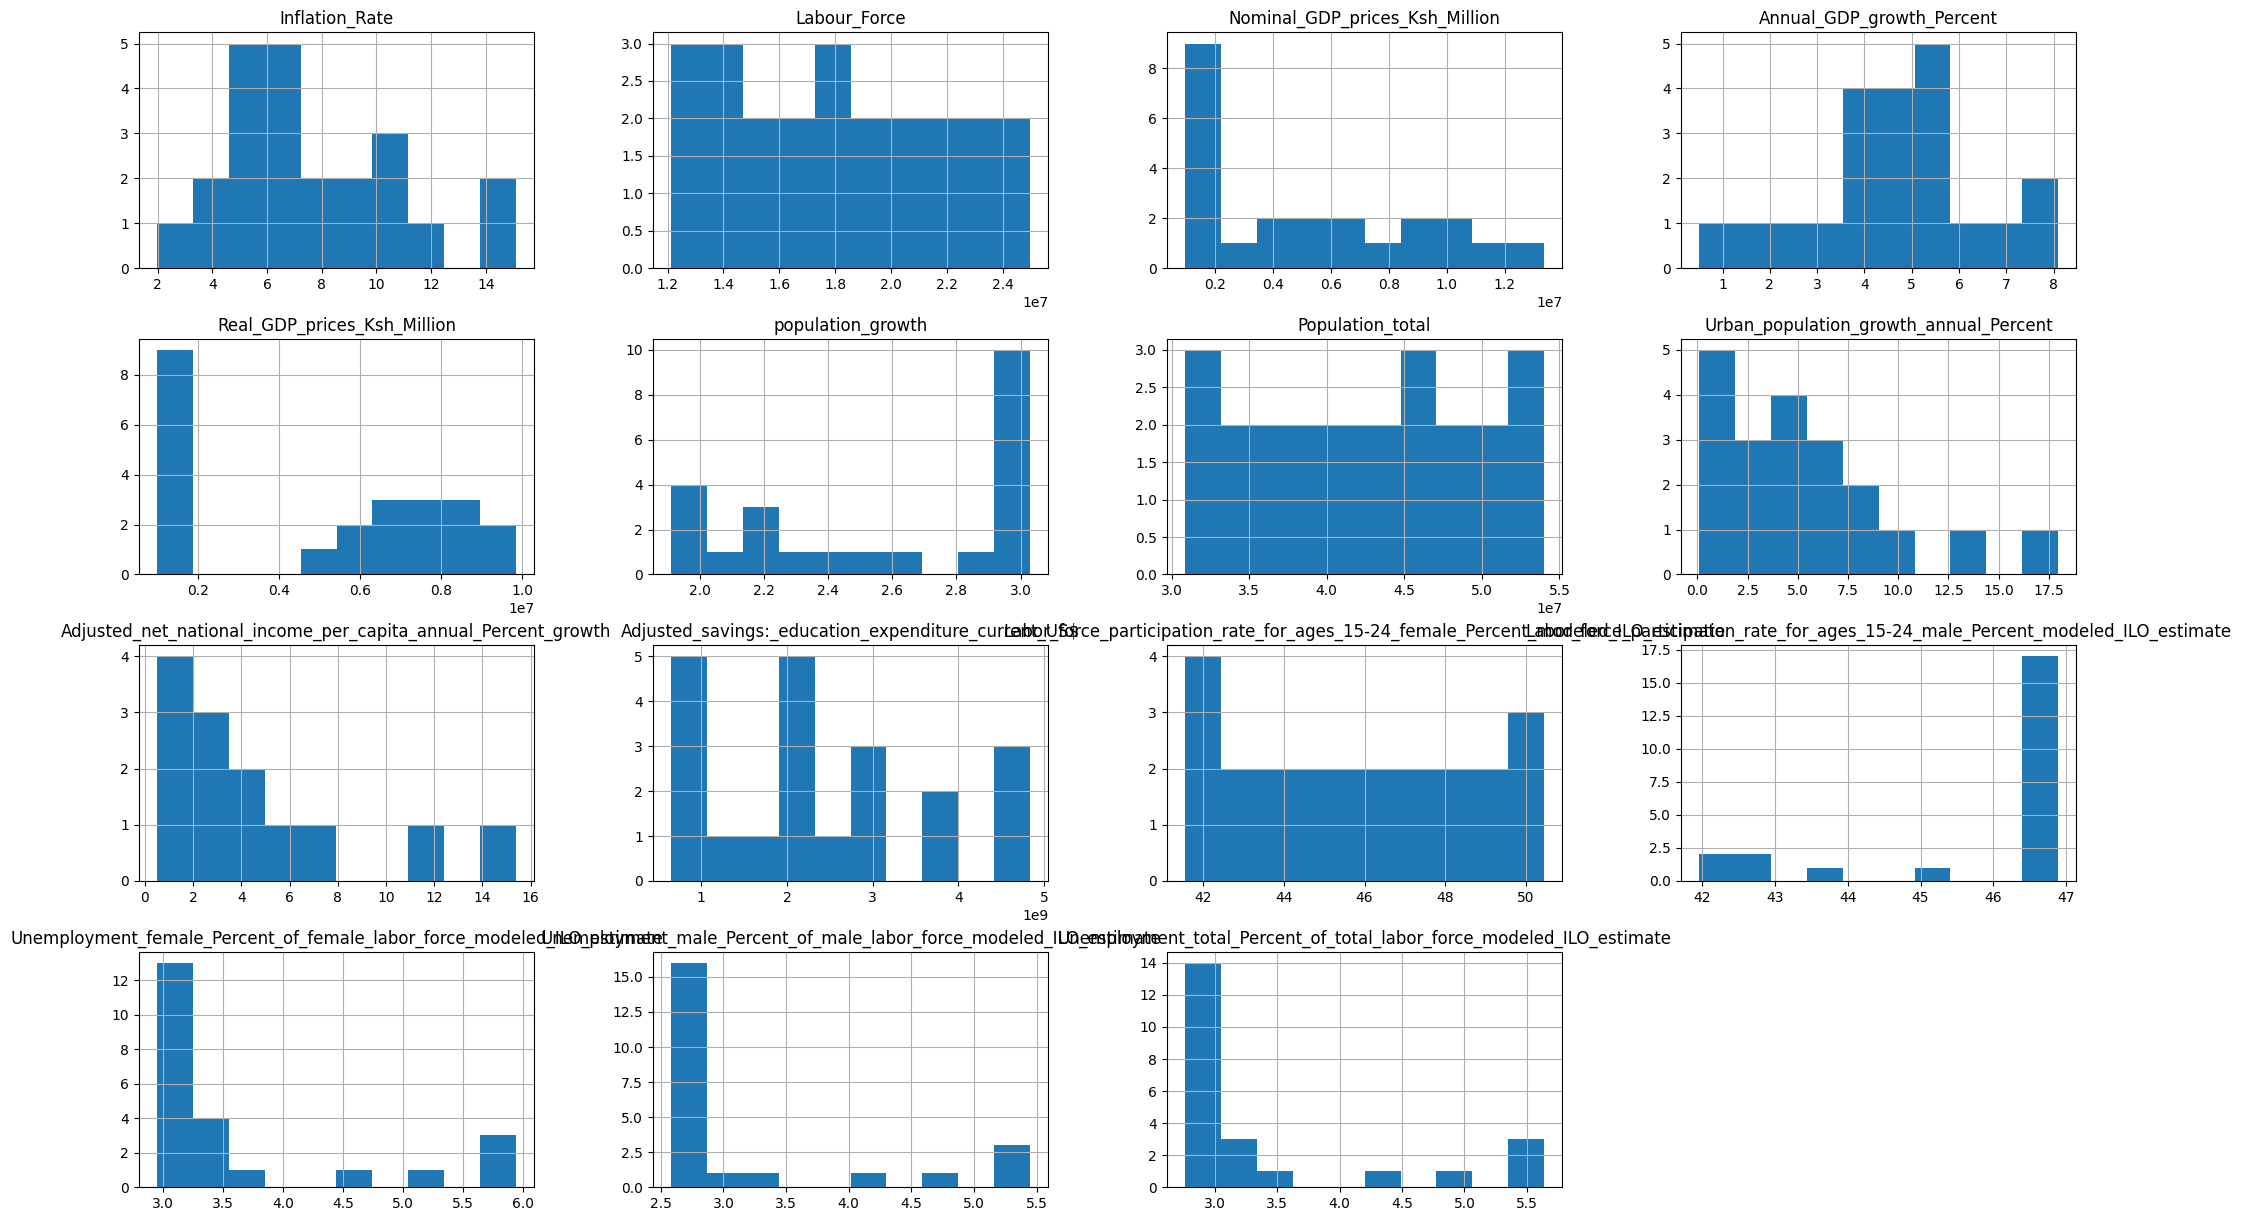

In [8]:
unemployment_historical.hist(figsize=(25,15))

# Visualise the target variable and check for seasonality and trend if any


Text(0.5, 1.0, 'Unemployment Rate in Kenya')

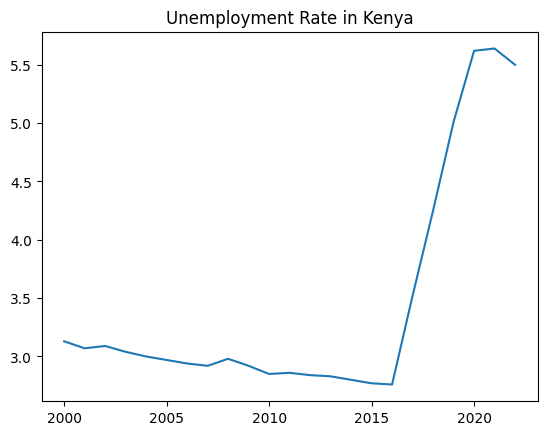

In [9]:
plt.plot(unemployment_historical.index,unemployment_historical['Unemployment_total_Percent_of_total_labor_force_modeled_ILO_estimate'])
plt.title("Unemployment Rate in Kenya")

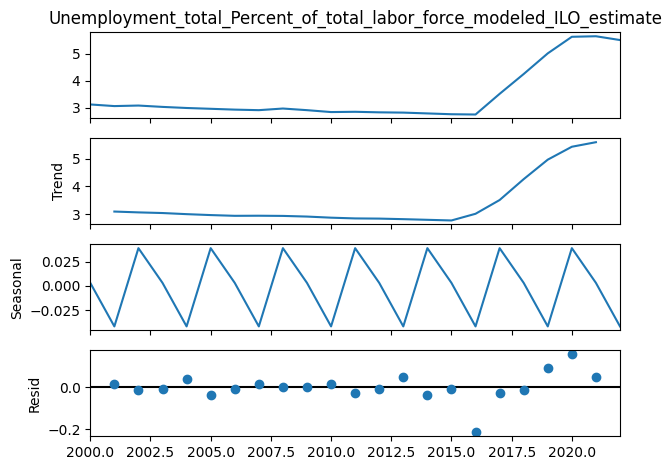

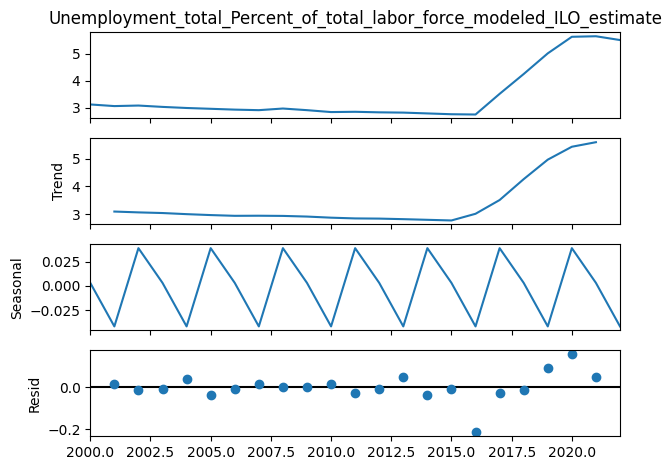

In [10]:
series = pd.Series(unemployment_historical['Unemployment_total_Percent_of_total_labor_force_modeled_ILO_estimate'])
results = seasonal_decompose(series, model='additive',period=3)
results.plot()

## Replace Nan values with mean and then scale data to common value using Min Max Scalar for percentages and non-percentages separately

In [20]:
unemployment_historical=unemployment_historical.fillna(unemployment_historical.mean())
unemployment_historical.describe().T

,count,mean,std,min,25%,50%,75%,max
Inflation_Rate,23.0,7.613043e+00,3.251344e+00,1.970000e+00,5.505000e+00,6.580000e+00,9.860000e+00,1.511000e+01
Labour_Force,23.0,1.812661e+07,3.912670e+06,1.211421e+07,1.490913e+07,1.792648e+07,2.128856e+07,2.498516e+07
Nominal_GDP_prices_Ksh_Million,23.0,5.138167e+06,3.968243e+06,9.678380e+05,1.519194e+06,4.162514e+06,8.038730e+06,1.336834e+07
Annual_GDP_growth_Percent,23.0,4.680952e+00,1.762390e+00,5.000000e-01,3.800000e+00,4.800000e+00,5.350000e+00,8.100000e+00
Real_GDP_prices_Ksh_Million,23.0,5.013512e+06,3.346256e+06,9.828550e+05,1.211127e+06,6.090206e+06,7.739792e+06,9.851329e+06
population_growth,23.0,2.563478e+00,4.305030e-01,1.910000e+00,2.190000e+00,2.660000e+00,2.970000e+00,3.030000e+00
Population_total,23.0,4.245514e+07,7.260731e+06,3.085161e+07,3.638413e+07,4.263514e+07,4.842140e+07,5.402749e+07
Urban_population_growth_annual_Percent,23.0,5.172500e+00,4.386516e+00,7.000000e-02,2.065000e+00,4.850000e+00,6.700000e+00,1.797000e+01
Adjusted_net_national_income_per_capita_annual_Percent_growth,23.0,4.741538e+00,3.164362e+00,4.900000e-01,3.040000e+00,4.741538e+00,4.741538e+00,1.540000e+01
Adjusted_savings:_education_expenditure_current_US$,23.0,2.385473e+09,1.286521e+09,6.451271e+08,1.462924e+09,2.078467e+09,3.053969e+09,4.837662e+09


In [21]:
scaling=MinMaxScaler()
percent_cols = [col for col in unemployment_historical.columns if "Percent" in str(unemployment_historical[col])]
non_percent_cols = [col for col in unemployment_historical.columns if "Percent" not in str(unemployment_historical[col])]
# Fit and transform the StandardScaler on non percent columns
scaled_data = scaling.fit_transform(unemployment_historical[non_percent_cols])
scaled_df = pd.DataFrame(scaled_data, columns=non_percent_cols)
scaled_df.head()

,Inflation_Rate,Labour_Force,Nominal_GDP_prices_Ksh_Million,Real_GDP_prices_Ksh_Million,population_growth,Population_total,Adjusted_savings:_education_expenditure_current_US$
0,0.609589,0.000000,0.000000,0.000000,0.901786,0.000000,0.000000
1,0.286149,0.037859,0.004208,0.004201,1.000000,0.040936,0.002605
2,0.000000,0.076851,0.005446,0.004818,1.000000,0.083199,0.026330
3,0.596651,0.115922,0.013221,0.008209,0.946429,0.125800,0.060213
4,0.748097,0.156239,0.024716,0.014262,0.964286,0.170014,0.087379


In [22]:
scaled_df.index=unemployment_historical.index

In [23]:
# Fit and transform the StandardScaler on non percent columns

percent_scaled_data = (unemployment_historical[percent_cols])/100
percent_scaled_df = pd.DataFrame(percent_scaled_data, columns=percent_cols)
percent_scaled_df.index

Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
      dtype='int32', name='Year')

In [24]:
percent_scaled_df.shape

(23, 8)

## Create the scaled final combined dataframe 

In [25]:
# combine both kind of data
scaled_dataframe=pd.concat([scaled_df,percent_scaled_df],axis=1)
# set index to year
#scaled_dataframe.index=unemployment_historical.index
# order the columns based on the original dataframe
#scaled_dataframe = scaled_dataframe[unemployment_historical.columns]
scaled_dataframe.shape

(23, 15)

array([[<Axes: title={'center': 'Inflation_Rate'}>,
        <Axes: title={'center': 'Labour_Force'}>,
        <Axes: title={'center': 'Nominal_GDP_prices_Ksh_Million'}>,
        <Axes: title={'center': 'Real_GDP_prices_Ksh_Million'}>],
       [<Axes: title={'center': 'population_growth'}>,
        <Axes: title={'center': 'Population_total'}>,
        <Axes: title={'center': 'Adjusted_savings:_education_expenditure_current_US$'}>,
        <Axes: title={'center': 'Annual_GDP_growth_Percent'}>],
       [<Axes: title={'center': 'Urban_population_growth_annual_Percent'}>,
        <Axes: title={'center': 'Adjusted_net_national_income_per_capita_annual_Percent_growth'}>,
        <Axes: title={'center': 'Labor_force_participation_rate_for_ages_15-24_female_Percent_modeled_ILO_estimate'}>,
        <Axes: title={'center': 'Labor_force_participation_rate_for_ages_15-24_male_Percent_modeled_ILO_estimate'}>],
       [<Axes: title={'center': 'Unemployment_female_Percent_of_female_labor_force_modeled

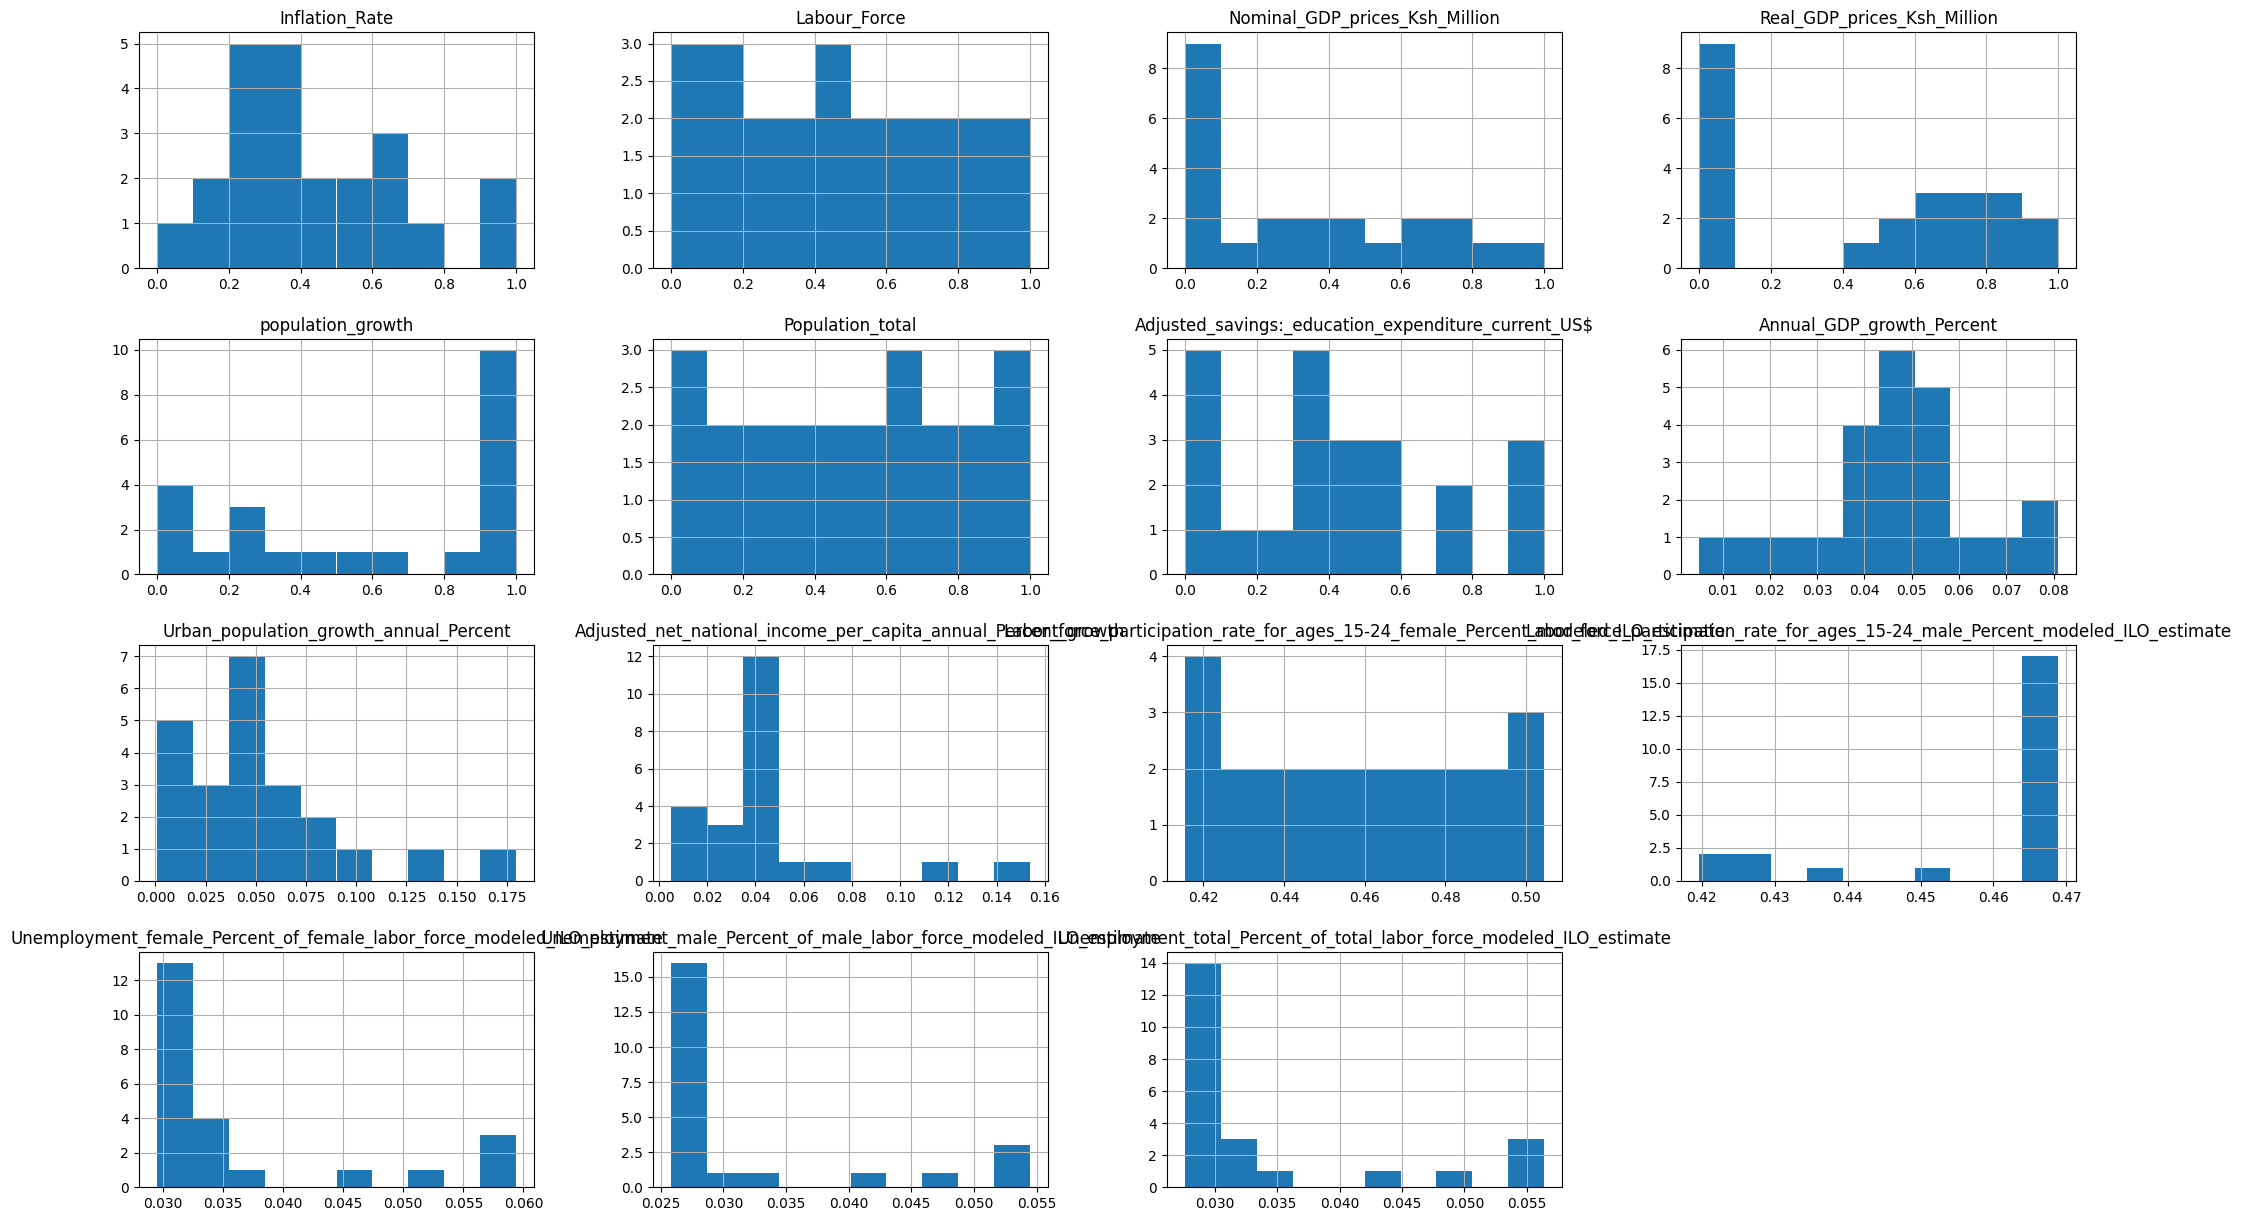

In [26]:
scaled_dataframe.hist(figsize=(25,15))


In [27]:
scaled_dataframe

,Inflation_Rate,Labour_Force,Nominal_GDP_prices_Ksh_Million,Real_GDP_prices_Ksh_Million,population_growth,Population_total,Adjusted_savings:_education_expenditure_current_US$,Annual_GDP_growth_Percent,Urban_population_growth_annual_Percent,Adjusted_net_national_income_per_capita_annual_Percent_growth,Labor_force_participation_rate_for_ages_15-24_female_Percent_modeled_ILO_estimate,Labor_force_participation_rate_for_ages_15-24_male_Percent_modeled_ILO_estimate,Unemployment_female_Percent_of_female_labor_force_modeled_ILO_estimate,Unemployment_male_Percent_of_male_labor_force_modeled_ILO_estimate,Unemployment_total_Percent_of_total_labor_force_modeled_ILO_estimate
Year,,,,,,,,,,,,,,,
2000,0.609589,0.000000,0.000000,0.000000,0.901786,0.000000,0.000000,0.04681,0.000700,0.047415,0.5046,0.4689,0.0337,0.0289,0.0313
2001,0.286149,0.037859,0.004208,0.004201,1.000000,0.040936,0.002605,0.03800,0.019500,0.047415,0.5003,0.4687,0.0331,0.0284,0.0307
2002,0.000000,0.076851,0.005446,0.004818,1.000000,0.083199,0.026330,0.00500,0.006700,0.047415,0.4961,0.4684,0.0333,0.0286,0.0309
2003,0.596651,0.115922,0.013221,0.008209,0.946429,0.125800,0.060213,0.02900,0.004900,0.047415,0.4918,0.4682,0.0328,0.0282,0.0304
2004,0.748097,0.156239,0.024716,0.014262,0.964286,0.170014,0.087379,0.05100,0.058200,0.027000,0.4876,0.4679,0.0323,0.0277,0.0300
2005,0.604262,0.196774,0.036126,0.021416,0.955357,0.215371,0.136090,0.05700,0.083000,0.051300,0.4834,0.4677,0.0320,0.0275,0.0297
2006,0.308980,0.237524,0.052798,0.030063,0.946429,0.262068,0.254031,0.06500,0.142900,0.109400,0.4791,0.4675,0.0317,0.0273,0.0294
2007,0.175038,0.278363,0.069810,0.039916,0.946429,0.310029,0.316596,0.06900,0.048500,0.017900,0.4748,0.4672,0.0314,0.0271,0.0292
2008,1.000000,0.320204,0.091912,0.042218,0.955357,0.359654,0.338843,0.01500,0.021800,0.047415,0.4705,0.4671,0.0319,0.0277,0.0298


array([[<Axes: title={'center': 'Inflation_Rate'}>,
        <Axes: title={'center': 'Labour_Force'}>,
        <Axes: title={'center': 'Nominal_GDP_prices_Ksh_Million'}>,
        <Axes: title={'center': 'Annual_GDP_growth_Percent'}>],
       [<Axes: title={'center': 'Real_GDP_prices_Ksh_Million'}>,
        <Axes: title={'center': 'population_growth'}>,
        <Axes: title={'center': 'Population_total'}>,
        <Axes: title={'center': 'Urban_population_growth_annual_Percent'}>],
       [<Axes: title={'center': 'Adjusted_net_national_income_per_capita_annual_Percent_growth'}>,
        <Axes: title={'center': 'Adjusted_savings:_education_expenditure_current_US$'}>,
        <Axes: title={'center': 'Labor_force_participation_rate_for_ages_15-24_female_Percent_modeled_ILO_estimate'}>,
        <Axes: title={'center': 'Labor_force_participation_rate_for_ages_15-24_male_Percent_modeled_ILO_estimate'}>],
       [<Axes: title={'center': 'Unemployment_female_Percent_of_female_labor_force_modeled

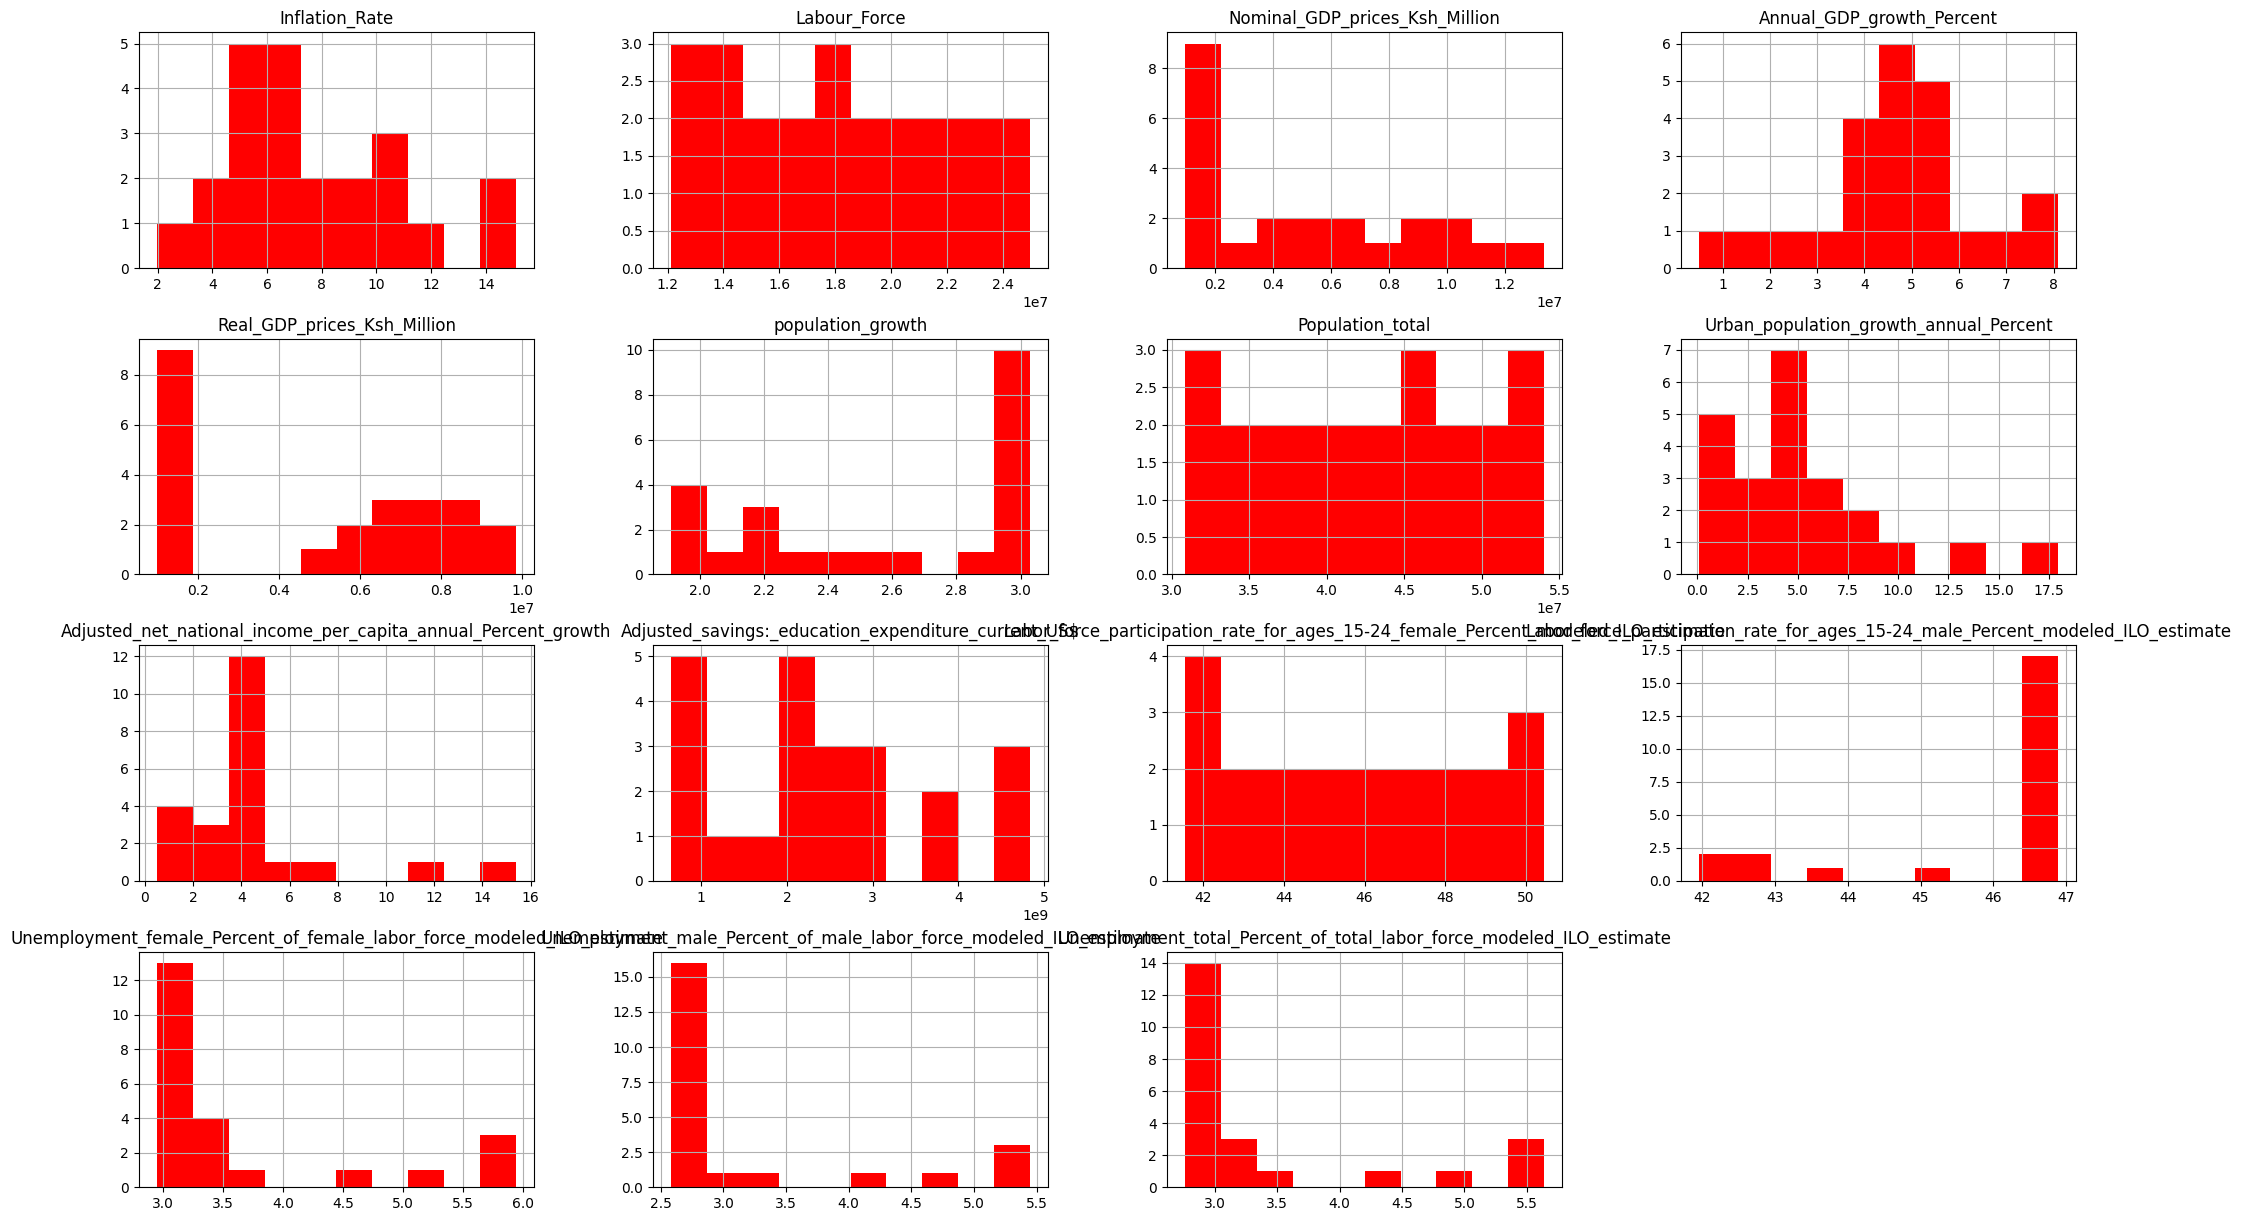

In [28]:
unemployment_historical.hist(figsize=(25,15),color='red')


Text(0.5, 1.0, 'Relative distribution of each feature')

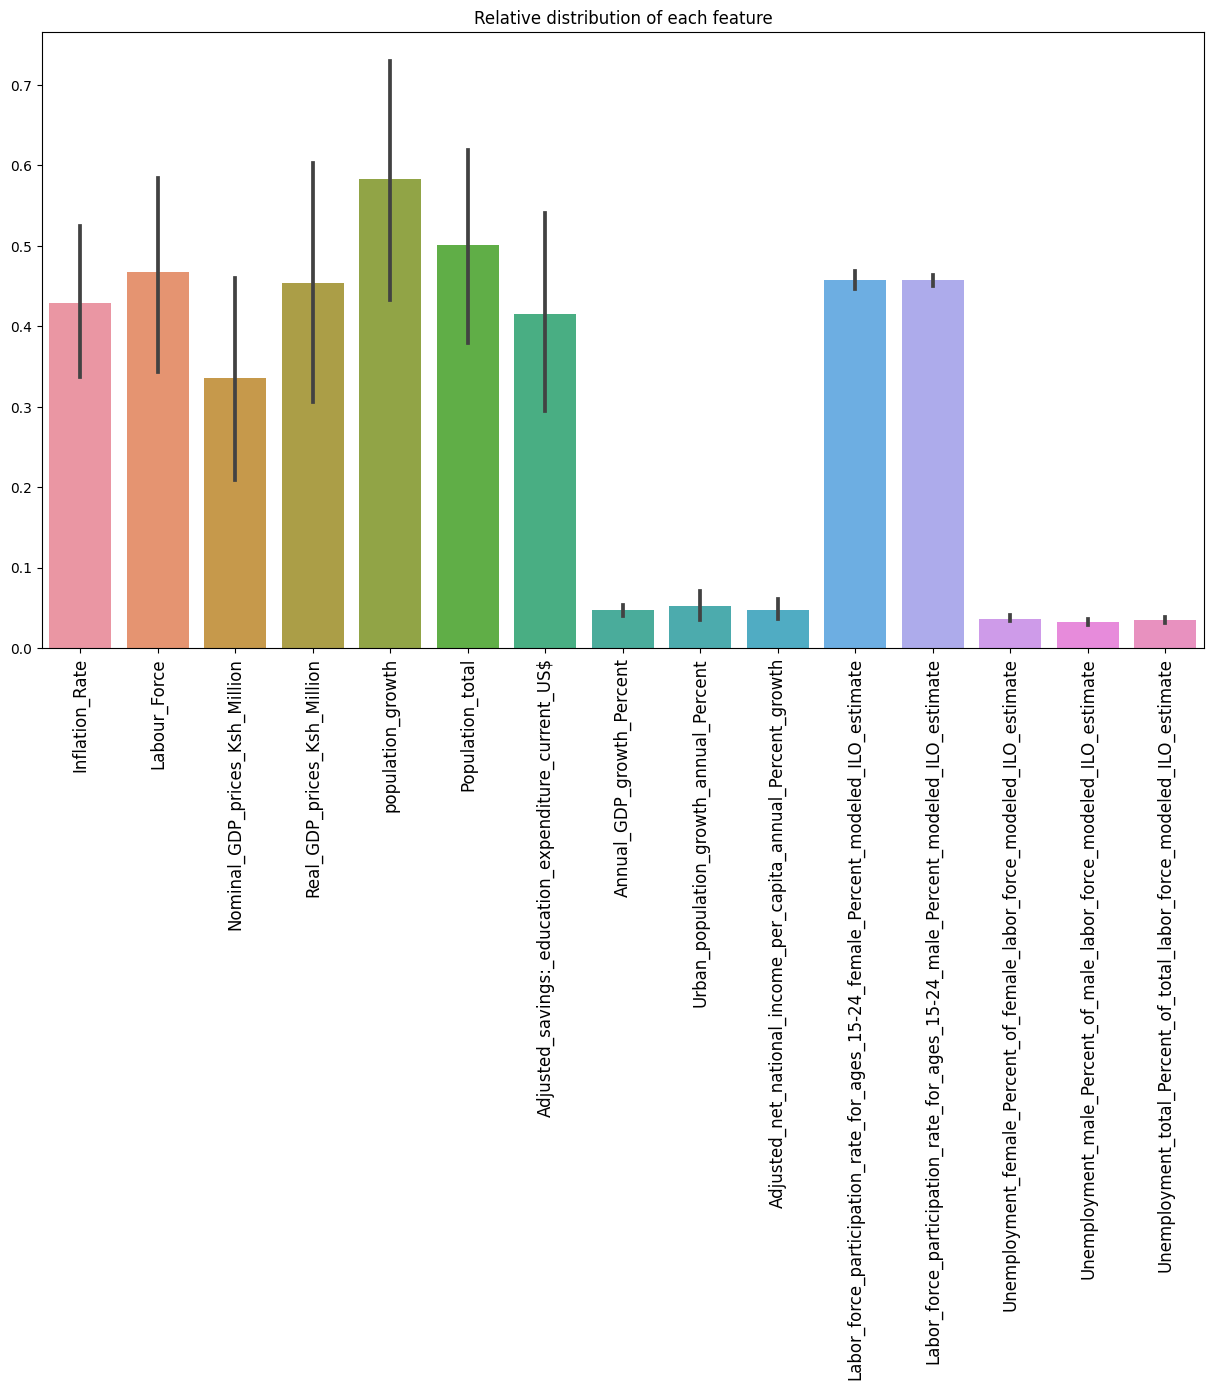

In [29]:
plt.figure(figsize=(15,8))
sns.barplot(data=scaled_dataframe)
plt.xticks(rotation=90,size=12)
plt.title("Relative distribution of each feature")

In [30]:
series = pd.Series(scaled_dataframe['Unemployment_total_Percent_of_total_labor_force_modeled_ILO_estimate'])
#results = seasonal_decompose(series, model='additive',period=3)
#results.plot()
scaled_dataframe

,Inflation_Rate,Labour_Force,Nominal_GDP_prices_Ksh_Million,Real_GDP_prices_Ksh_Million,population_growth,Population_total,Adjusted_savings:_education_expenditure_current_US$,Annual_GDP_growth_Percent,Urban_population_growth_annual_Percent,Adjusted_net_national_income_per_capita_annual_Percent_growth,Labor_force_participation_rate_for_ages_15-24_female_Percent_modeled_ILO_estimate,Labor_force_participation_rate_for_ages_15-24_male_Percent_modeled_ILO_estimate,Unemployment_female_Percent_of_female_labor_force_modeled_ILO_estimate,Unemployment_male_Percent_of_male_labor_force_modeled_ILO_estimate,Unemployment_total_Percent_of_total_labor_force_modeled_ILO_estimate
Year,,,,,,,,,,,,,,,
2000,0.609589,0.000000,0.000000,0.000000,0.901786,0.000000,0.000000,0.04681,0.000700,0.047415,0.5046,0.4689,0.0337,0.0289,0.0313
2001,0.286149,0.037859,0.004208,0.004201,1.000000,0.040936,0.002605,0.03800,0.019500,0.047415,0.5003,0.4687,0.0331,0.0284,0.0307
2002,0.000000,0.076851,0.005446,0.004818,1.000000,0.083199,0.026330,0.00500,0.006700,0.047415,0.4961,0.4684,0.0333,0.0286,0.0309
2003,0.596651,0.115922,0.013221,0.008209,0.946429,0.125800,0.060213,0.02900,0.004900,0.047415,0.4918,0.4682,0.0328,0.0282,0.0304
2004,0.748097,0.156239,0.024716,0.014262,0.964286,0.170014,0.087379,0.05100,0.058200,0.027000,0.4876,0.4679,0.0323,0.0277,0.0300
2005,0.604262,0.196774,0.036126,0.021416,0.955357,0.215371,0.136090,0.05700,0.083000,0.051300,0.4834,0.4677,0.0320,0.0275,0.0297
2006,0.308980,0.237524,0.052798,0.030063,0.946429,0.262068,0.254031,0.06500,0.142900,0.109400,0.4791,0.4675,0.0317,0.0273,0.0294
2007,0.175038,0.278363,0.069810,0.039916,0.946429,0.310029,0.316596,0.06900,0.048500,0.017900,0.4748,0.4672,0.0314,0.0271,0.0292
2008,1.000000,0.320204,0.091912,0.042218,0.955357,0.359654,0.338843,0.01500,0.021800,0.047415,0.4705,0.4671,0.0319,0.0277,0.0298


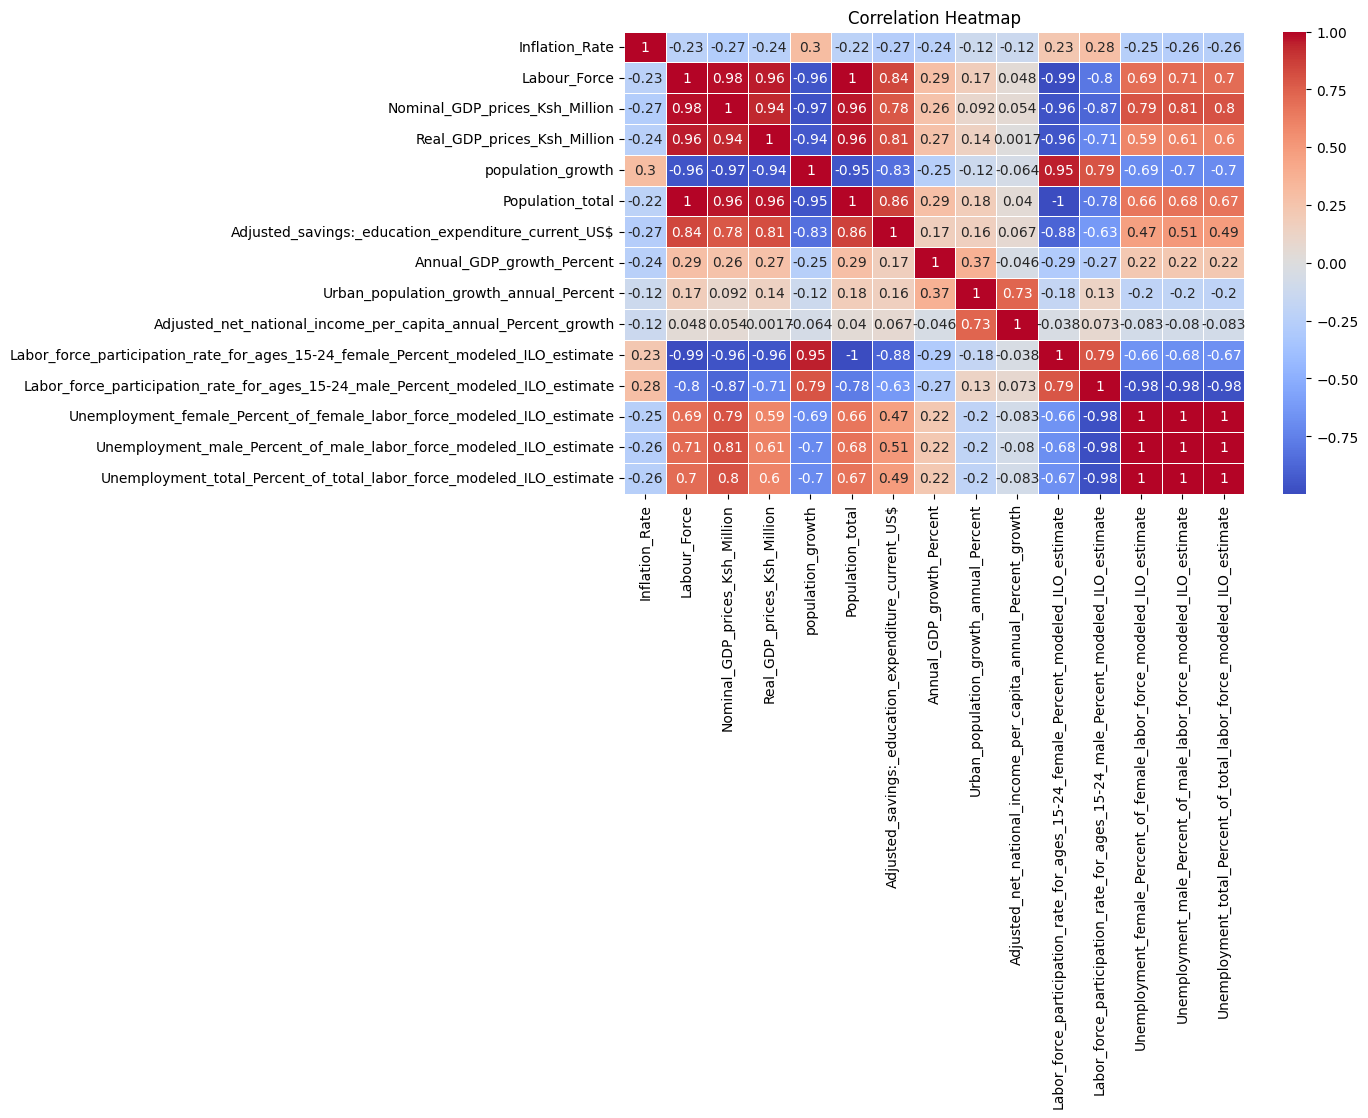

In [31]:
correlation_matrix = scaled_dataframe.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [32]:
#importing sweetviz and visualizing our data

sweet_report = sv.analyze(scaled_dataframe)
sweet_report.show_html('Kaur_scaled_sweetviz_final.html')

                                             |          | [  0%]   00:00 -> (? left)

Report Kaur_scaled_sweetviz_final.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


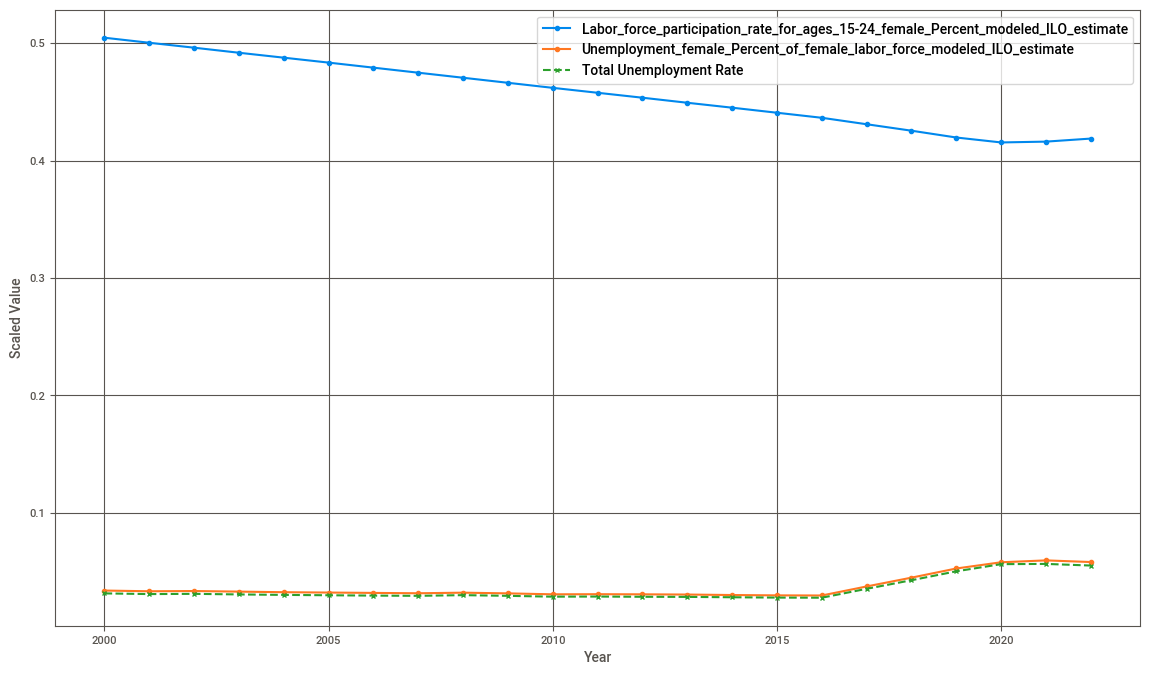

In [33]:
lineplot('female',scaled_dataframe)

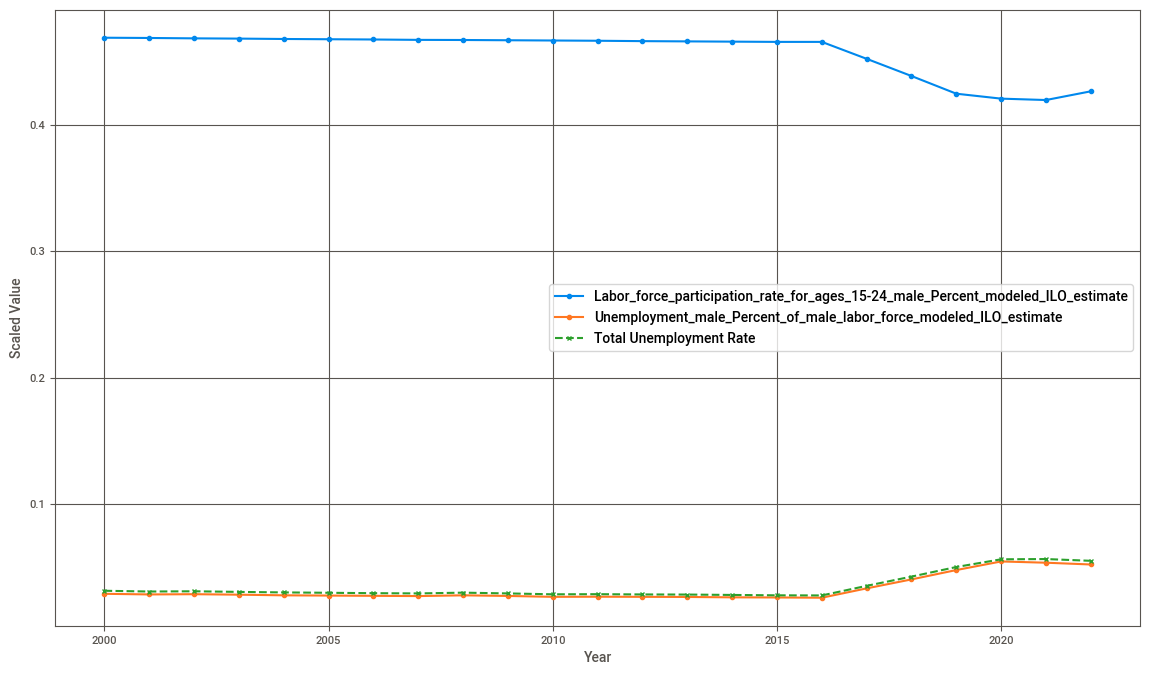

In [35]:
lineplot('_male',scaled_dataframe)

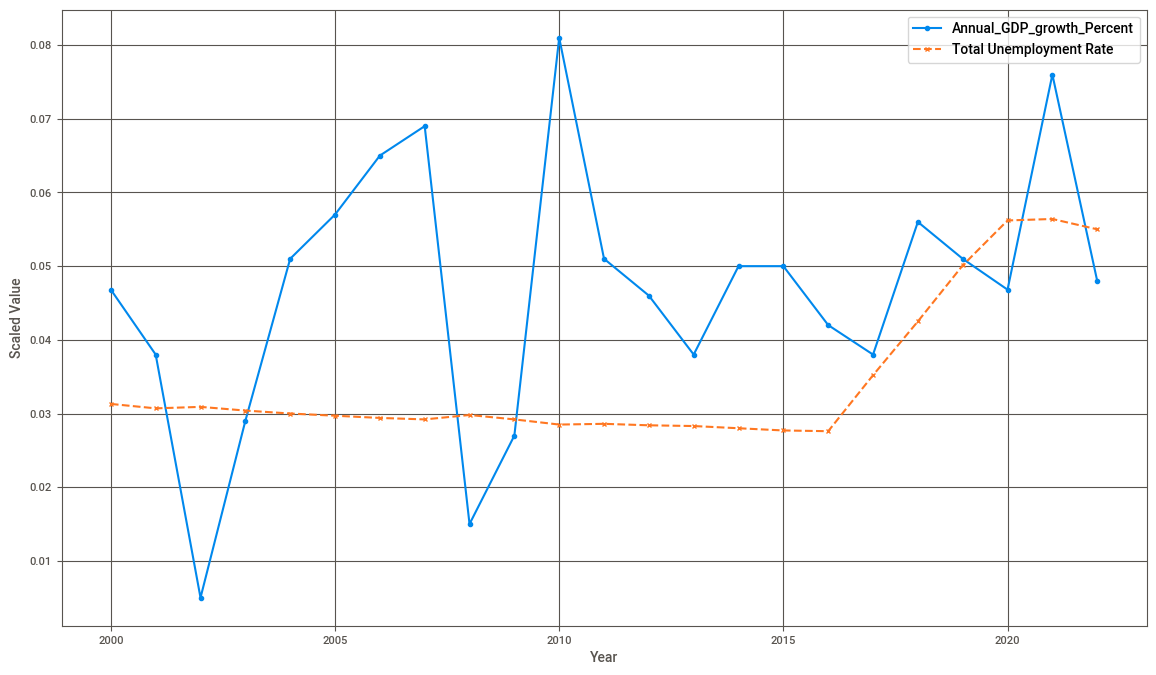

In [66]:
lineplot('gdp_g',scaled_dataframe)


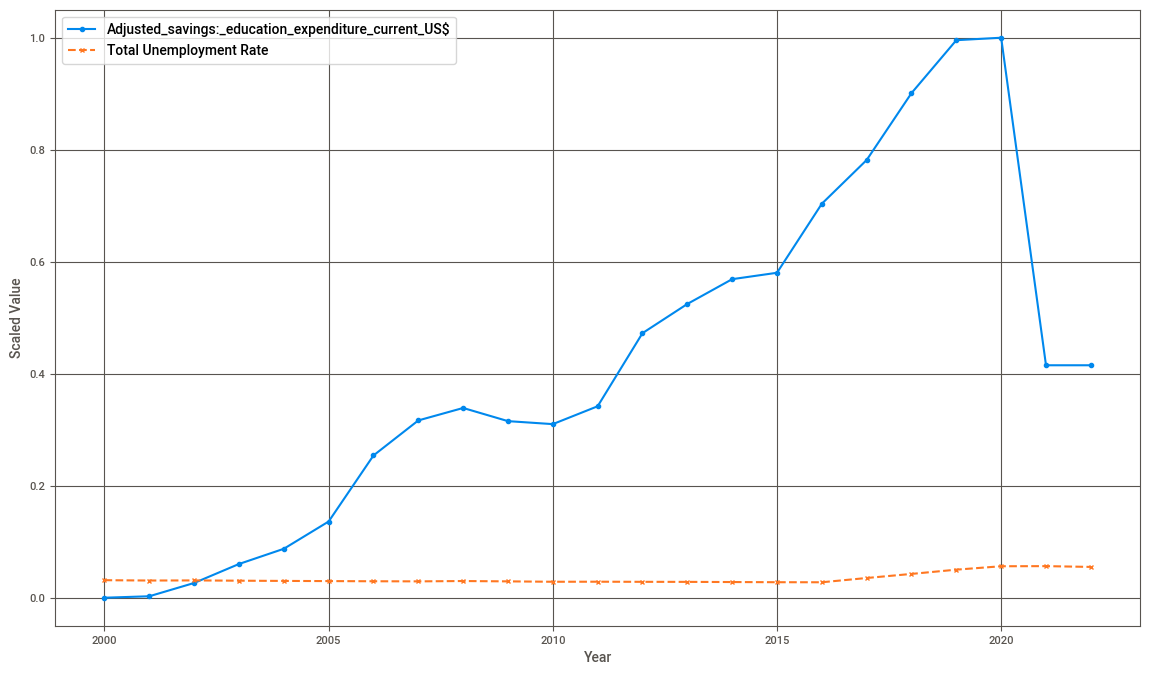

In [95]:
lineplot('expend',scaled_dataframe)

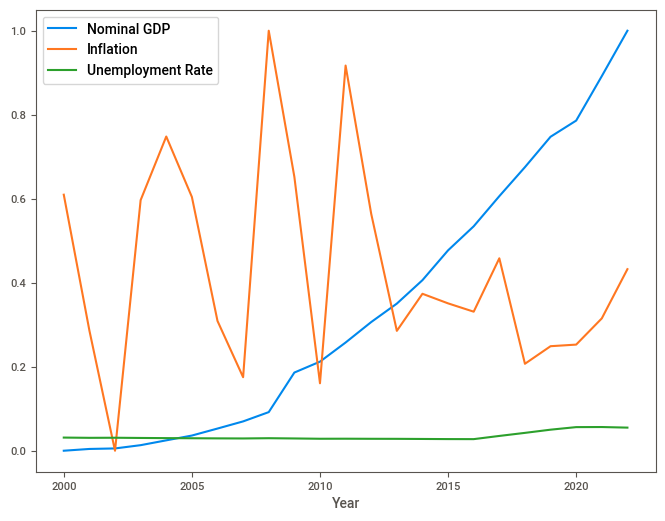

In [78]:
plt.figure(figsize=(8,6))
sns.lineplot(scaled_dataframe,y="Nominal_GDP_prices_Ksh_Million",x=scaled_dataframe.index,label="Nominal GDP")
sns.lineplot(scaled_dataframe,y="Inflation_Rate",x=scaled_dataframe.index,label="Inflation")
sns.lineplot(scaled_dataframe,y="Unemployment_total_Percent_of_total_labor_force_modeled_ILO_estimate",x=scaled_dataframe.index,label="Unemployment Rate")
plt.ylabel("")
plt.legend()



<Axes: xlabel='Year', ylabel='Unemployment_total_Percent_of_total_labor_force_modeled_ILO_estimate'>

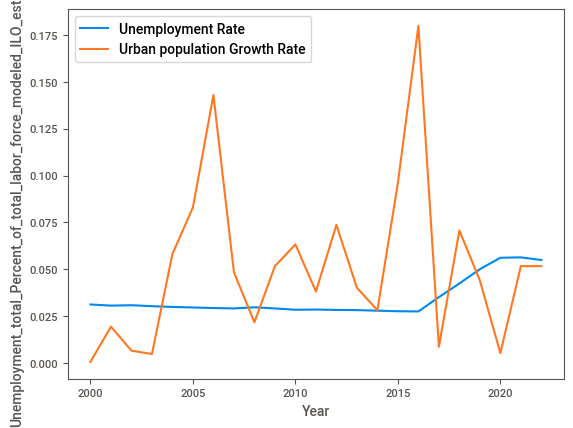

In [94]:
sns.lineplot(scaled_dataframe,y="Unemployment_total_Percent_of_total_labor_force_modeled_ILO_estimate",x=scaled_dataframe.index,label="Unemployment Rate")
sns.lineplot(scaled_dataframe,y="Urban_population_growth_annual_Percent",x=scaled_dataframe.index,label="Urban population Growth Rate")


In [60]:
male_unemp=unemployment_historical["Unemployment_male_Percent_of_male_labor_force_modeled_ILO_estimate"]
female_unemp=unemployment_historical["Unemployment_female_Percent_of_female_labor_force_modeled_ILO_estimate"]
male_unemp

0     2.89
1     2.84
2     2.86
3     2.82
4     2.77
5     2.75
6     2.73
7     2.71
8     2.77
9     2.72
10    2.65
11    2.66
12    2.65
13    2.64
14    2.61
15    2.60
16    2.58
17    3.32
18    4.03
19    4.77
20    5.45
21    5.35
22    5.21
Name: Unemployment_male_Percent_of_male_labor_force_modeled_ILO_estimate, dtype: float64

<Axes: title={'center': 'Unemeployment Rate based on Gender'}, ylabel='Percent'>

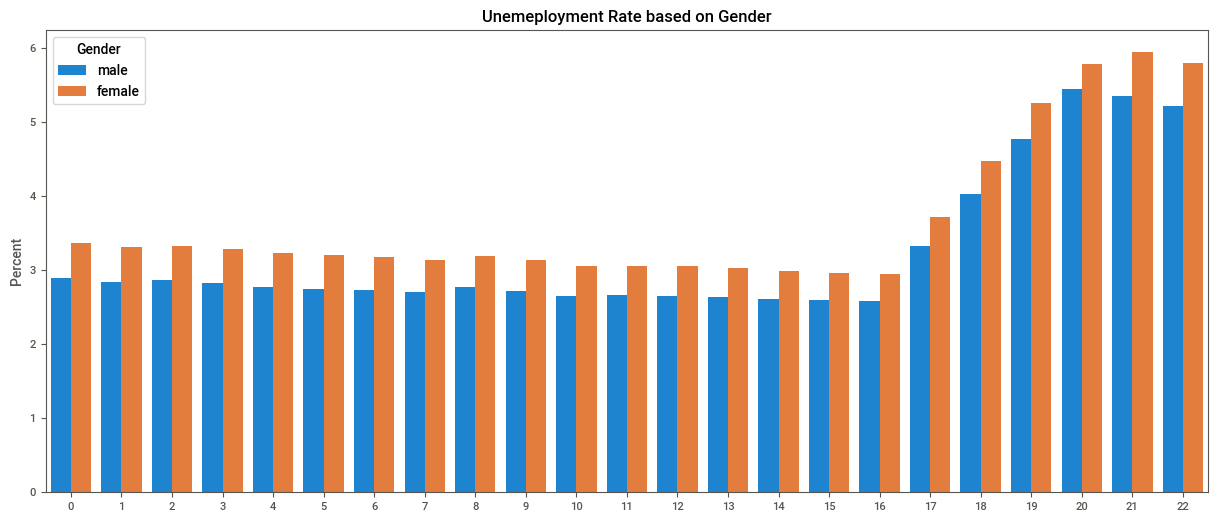

In [61]:


# Create DataFrames for 'male' and 'female' data
male_df = pd.DataFrame({'Percent': male_unemp, 'Gender': 'male'})
female_df = pd.DataFrame({'Percent': female_unemp, 'Gender': 'female'})

# Concatenate the DataFrames
result_df = pd.concat([male_df, female_df])
plt.figure(figsize=(15, 6))
plt.title("Unemeployment Rate based on Gender")

sns.barplot(result_df, y='Percent',x=result_df.index, hue='Gender')